In [10]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel, AdamW
from tqdm import tqdm

# Enable anomaly detection to debug gradient issues
torch.autograd.set_detect_anomaly(True)

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = clip_model.to(device)

# Custom Dataset
class ImagePredictionDataset(Dataset):
    def __init__(self, tsv_data, image_dir):
        self.data = tsv_data
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        compound = row["compound"]

        # Dynamically generate candidates from available columns
        sequence_images = [
            row[col]
            for col in self.data.columns
            if col.startswith("image") and col.endswith("name") and not pd.isna(row[col])
        ]
        candidate_images = sequence_images[-3:]  # Use the last 3 sequence images as candidates
        captions = f"{row['sequence_caption1']} {row['sequence_caption2']}"

        # Load sequence images
        sequence_paths = [os.path.join(self.image_dir, compound, img) for img in sequence_images]
        sequence_images = [self.load_image(path) for path in sequence_paths]

        # Load candidate images
        candidate_paths = [os.path.join(self.image_dir, compound, img) for img in candidate_images]
        candidate_images = [self.load_image(path) for path in candidate_paths]

        return torch.stack(sequence_images), torch.stack(candidate_images), captions, candidate_paths

    def load_image(self, path):
        try:
            img = Image.open(path).convert("RGB")
            return clip_processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)
        except Exception as e:
            print(f"Error loading image: {path}, Error: {e}")
            return torch.zeros((3, 224, 224))  # Return a blank tensor if loading fails

# Fine-tuning parameters
LEARNING_RATE = 5e-5
EPOCHS = 10
BATCH_SIZE = 4

# Load TSV file and create dataset
def load_dataset(tsv_file, base_dir):
    tsv_path = os.path.join(base_dir, tsv_file)
    tsv_data = pd.read_csv(tsv_path, sep="\t")
    dataset = ImagePredictionDataset(tsv_data, base_dir)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer
optimizer = AdamW(clip_model.parameters(), lr=LEARNING_RATE)

def train_model(dataloader):
    clip_model.train()
    correct_predictions = 0
    total_predictions = 0

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}")
        epoch_loss = 0.0

        for batch in tqdm(dataloader):
            sequence_images, candidate_images, captions, candidate_paths = batch
            optimizer.zero_grad()

            # Move images to device
            sequence_images = sequence_images.to(device)  # Shape: (BATCH_SIZE, SEQ_COUNT, 3, 224, 224)
            candidate_images = candidate_images.to(device)  # Shape: (BATCH_SIZE, CAND_COUNT, 3, 224, 224)

            # Flatten images for processing
            B, SEQ_COUNT, C, H, W = sequence_images.shape
            _, CAND_COUNT, _, _, _ = candidate_images.shape

            sequence_images_flat = sequence_images.view(B * SEQ_COUNT, C, H, W)
            candidate_images_flat = candidate_images.view(B * CAND_COUNT, C, H, W)

            # Process sequence images
            sequence_features = clip_model.get_image_features(pixel_values=sequence_images_flat)
            sequence_features = sequence_features / sequence_features.norm(dim=-1, keepdim=True)
            sequence_avg = sequence_features.view(B, SEQ_COUNT, -1).mean(dim=1)  # Averaged over sequence

            # Process candidate images
            candidate_features = clip_model.get_image_features(pixel_values=candidate_images_flat)
            candidate_features = candidate_features / candidate_features.norm(dim=-1, keepdim=True)
            candidate_features = candidate_features.view(B, CAND_COUNT, -1)

            # Process captions
            text_inputs = clip_processor(
                text=list(captions),
                return_tensors="pt",
                padding=True,
                truncation=True,  # Ensure text does not exceed max length
                max_length=77     # Explicitly set max length for CLIP
            ).to(device)
            text_features = clip_model.get_text_features(**text_inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # Combine sequence and text features
            combined_embedding = (sequence_avg + text_features) / 2

            # Compute similarity
            similarities = torch.einsum("bd,bcd->bc", combined_embedding, candidate_features)
            predictions = similarities.argmax(dim=1)

            # Calculate loss (CrossEntropy)
            labels = torch.zeros(B, dtype=torch.long).to(device)
            loss = torch.nn.functional.cross_entropy(similarities, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            correct_predictions += (predictions == 0).sum().item()  # Index 0 corresponds to ground truth
            total_predictions += B

        accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch+1} Loss: {epoch_loss / len(dataloader):.4f} Accuracy: {accuracy:.4f}")

# Run training for Subtask B
SUBTASK_B_TRAIN_PATH = "/content/drive/MyDrive/nlp dataset/AdMIRe Subtask B Train/train"
dataloader_b = load_dataset("/content/drive/MyDrive/nlp dataset/AdMIRe Subtask B Train/train/subtask_b_train.tsv", SUBTASK_B_TRAIN_PATH)
train_model(dataloader_b)



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10


100%|██████████| 5/5 [00:13<00:00,  2.66s/it]


Epoch 1 Loss: 1.1011 Accuracy: 0.3500
Epoch 2/10


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 2 Loss: 1.0876 Accuracy: 0.3750
Epoch 3/10


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 3 Loss: 1.0497 Accuracy: 0.5000
Epoch 4/10


100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Epoch 4 Loss: 0.9259 Accuracy: 0.6000
Epoch 5/10


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


Epoch 5 Loss: 0.9509 Accuracy: 0.6500
Epoch 6/10


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 6 Loss: 0.8171 Accuracy: 0.6917
Epoch 7/10


100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 7 Loss: 0.9342 Accuracy: 0.7214
Epoch 8/10


100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


Epoch 8 Loss: 1.0453 Accuracy: 0.7438
Epoch 9/10


100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Epoch 9 Loss: 1.0806 Accuracy: 0.7611
Epoch 10/10


100%|██████████| 5/5 [00:12<00:00,  2.44s/it]

Epoch 10 Loss: 1.0294 Accuracy: 0.7550


Testing:   0%|          | 0/3 [00:00<?, ?it/s]

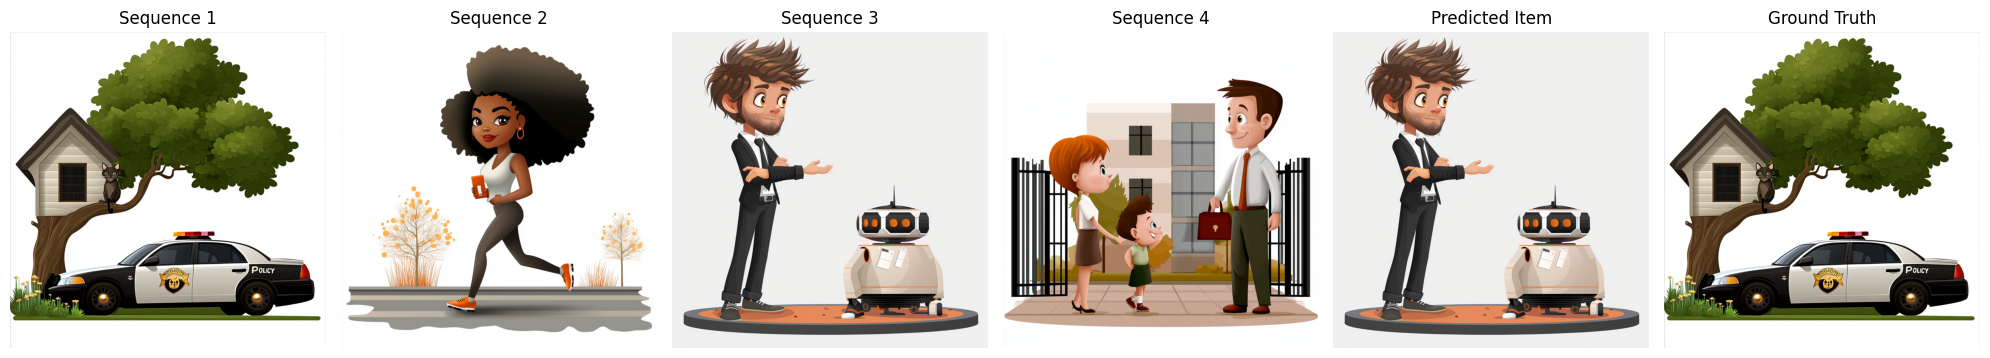

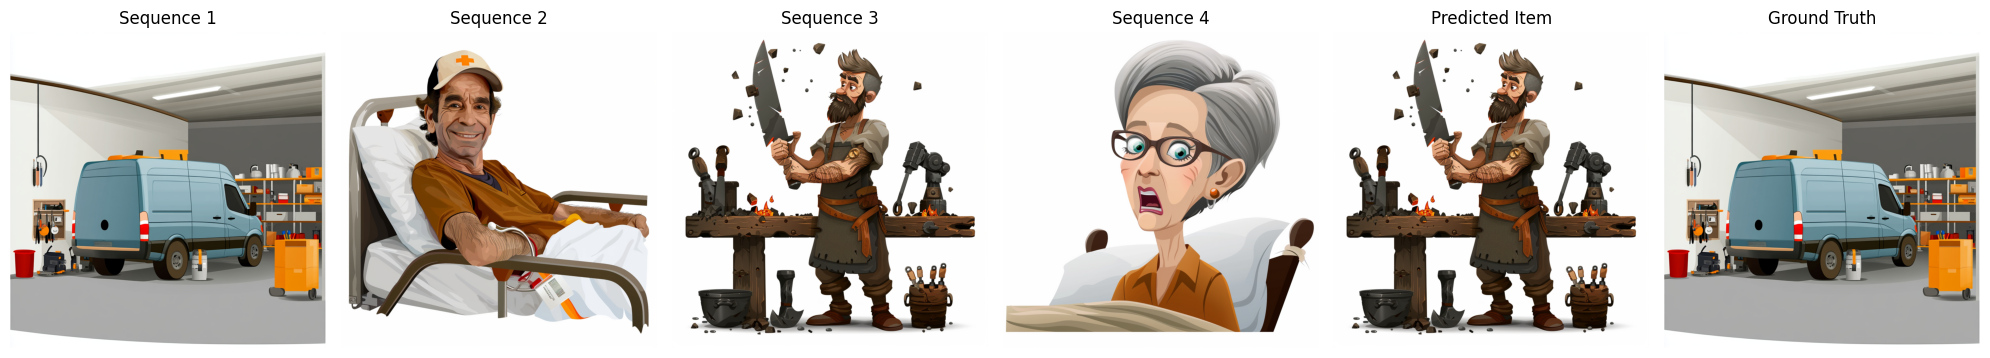

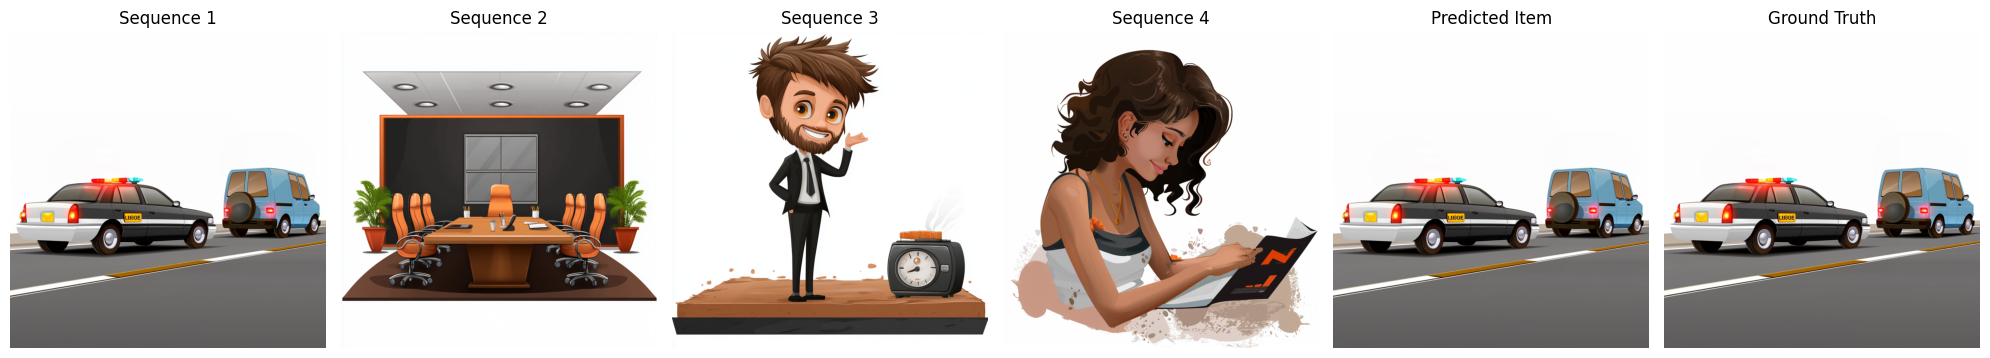

Testing:   0%|          | 0/3 [00:08<?, ?it/s]


IndexError: list index out of range

In [46]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from tqdm import tqdm

# Function to display images and captions
def display_images(compound, seq_image_paths, predicted_item_path, ground_truth_path):
    """
    Displays the sequence of images and the predicted vs ground truth images.

    Parameters:
    - compound: The caption or identifier for the images.
    - seq_image_paths: List of paths to the sequence images.
    - predicted_item_path: Path to the predicted next image.
    - ground_truth_path: Path to the ground truth next image.
    """
    fig, axes = plt.subplots(1, len(seq_image_paths) + 2, figsize=(20, 8))  # Adjust figure size for visibility

    # Display sequence images
    for idx, img_path in enumerate(seq_image_paths):
        axes[idx].imshow(Image.open(img_path))
        axes[idx].set_title(f"Sequence {idx + 1}")
        axes[idx].axis("off")

    # Display predicted and ground truth images
    axes[len(seq_image_paths)].imshow(Image.open(predicted_item_path))
    axes[len(seq_image_paths)].set_title("Predicted Item")
    axes[len(seq_image_paths)].axis("off")

    axes[len(seq_image_paths) + 1].imshow(Image.open(ground_truth_path))
    axes[len(seq_image_paths) + 1].set_title("Ground Truth")
    axes[len(seq_image_paths) + 1].axis("off")

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Testing function with visualization
def test_model_with_display(dataloader):
    clip_model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation
        count = 0
        for batch in tqdm(dataloader, desc="Testing"):
            if count == 2:  # Limit to two cases
                break

            sequence_images, candidate_images, captions, candidate_paths = batch

            # Move images to the device
            sequence_images = sequence_images.to(device)
            candidate_images = candidate_images.to(device)

            # Flatten images for processing
            B, SEQ_COUNT, C, H, W = sequence_images.shape
            _, CAND_COUNT, _, _, _ = candidate_images.shape

            sequence_images_flat = sequence_images.view(B * SEQ_COUNT, C, H, W)
            candidate_images_flat = candidate_images.view(B * CAND_COUNT, C, H, W)

            # Process sequence images
            sequence_features = clip_model.get_image_features(pixel_values=sequence_images_flat)
            sequence_features = sequence_features / sequence_features.norm(dim=-1, keepdim=True)
            sequence_avg = sequence_features.view(B, SEQ_COUNT, -1).mean(dim=1)

            # Process candidate images
            candidate_features = clip_model.get_image_features(pixel_values=candidate_images_flat)
            candidate_features = candidate_features / candidate_features.norm(dim=-1, keepdim=True)
            candidate_features = candidate_features.view(B, CAND_COUNT, -1)

            # Process captions
            text_inputs = clip_processor(
                text=list(captions),
                return_tensors="pt",
                padding=True,
                truncation=True,  # Ensure text does not exceed max length
                max_length=77     # Explicitly set max length for CLIP
            ).to(device)
            text_features = clip_model.get_text_features(**text_inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # Combine sequence and text features
            combined_embedding = (sequence_avg + text_features) / 2

            # Compute similarity and get prediction
            similarities = torch.einsum("bd,bcd->bc", combined_embedding, candidate_features)
            predictions = similarities.argmax(dim=1)

            # Loop through the batch for visualization
            for i in range(B):
                # Ensure we don't go out of range by checking the length of candidate_paths
                if len(candidate_paths[i]) < SEQ_COUNT:
                    print(f"Warning: Not enough images for {captions[i]}. Skipping this sample.")
                    continue  # Skip if the sequence length is too short

                # Retrieve sequence image paths and candidate paths separately
                seq_image_paths = [
                    candidate_paths[i][j]
                    for j in range(min(SEQ_COUNT, len(candidate_paths[i])))  # Safeguard against index out of range
                ]  # Sequence images paths

                predicted_item_path = candidate_paths[i][predictions[i].item()]
                ground_truth_path = candidate_paths[i][0]  # Ground truth is always the first candidate

                # Display images for this sample
                display_images(captions[i], seq_image_paths, predicted_item_path, ground_truth_path)

            count += 1  # Increment counter after processing each batch


TEST_DIR = "/content/drive/MyDrive/nlp dataset/AdMIRe Subtask B Sample/train"
TEST_TSV = "/content/drive/MyDrive/nlp dataset/AdMIRe Subtask B Sample/train/subtask_b_train.tsv"

# Load test dataset
test_dataloader = load_dataset(TEST_TSV, TEST_DIR)

# Test the model and visualize predictions
test_model_with_display(test_dataloader)
